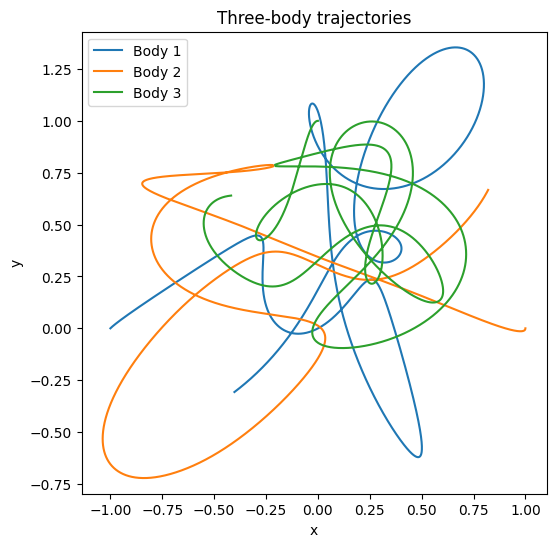

<class 'scipy.integrate._ivp.ivp.OdeResult'>
(3, 10000) <class 'numpy.ndarray'>


In [1]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print(x.shape, type(y))
# print((x1.shape), type(y1))

In [2]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)


print(min(vx_sig[0]))
print(min(vy_sig[0]))



0.1560552232688204
0.0031827263277546536


In [3]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:


# prev = np.roll(data, shift=1, axis=0)  # previous row values
# prev[0] = np.nan   # first row has no previous row
# print(prev.shape)

# lagged = np.hstack([data, prev])

print(data.shape)

# # Create lagged features
X = data[:-1]
y = data[1:]

print(X.shape, y.shape)

# # Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# # Reshape the input data to 3D for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



(10000, 12)
(9999, 12) (9999, 12)
<class 'numpy.ndarray'>


In [6]:


# model = Sequential([
#     LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(12)
# ])

# model.compile(optimizer='adam', loss='mse')

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# loss = model.evaluate(X_test, y_test)
# print(f'Test loss: {loss}')


# y_pred = model.predict(X_test)


In [7]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Model training history')
# plt.legend()
# plt.show()


In [ ]:
# from sklearn.metrics import r2_score, mean_absolute_error

# def smape(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
#     diff = np.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0  # avoid division by zero
#     return 100 * np.mean(diff)  

# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)


# score = smape(y_test, y_pred)
# print(f"SMAPE: {score:.2f}%")

# print(f"Test MAE: {mae:.4f}")
# print(f"Test R²: {r2:.4f}")

NameError: name 'y_pred' is not defined

In [40]:
print(type(X_train))

<class 'numpy.ndarray'>


In [ ]:
from LSTMCell import LSTM
import torch
import torch.nn as nn

input_window_size = 12
hidden_size = 10
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.training_loop(num_epochs = 10, 
                    criterion = criterion,
                    optimizer = optimizer,
                    trainX = X_train,
                    trainY = y_train)